In [51]:
import numpy as np
np.seterr(all='raise')

import pint
si = pint.UnitRegistry()

In [52]:
from matplotlib import pyplot
si.setup_matplotlib()

In [53]:
%run mpdata.ipynb

In [54]:
%run coord.ipynb

1e-06
1e-06 meter
1.0


In [55]:
def plot_init():
    pyplot.figure(figsize=(15,9))

def plot_done(title):
    pyplot.title(title)
    pyplot.grid()
    pyplot.legend()
    pyplot.show()
    
def plot_pdfr(r_min, r_max, cdf):
    cdfarg = np.linspace(r_min.magnitude, r_max.magnitude, 1000) * r_min.units
    x = cdfarg[0:-1] + (cdfarg[1:] - cdfarg[0:-1])/2
    y = np.diff(cdf(cdfarg)) / np.diff(cdfarg.magnitude)
    pyplot.plot(x, y)
    
def plot_step(r, pdf, t):
    pyplot.step(r, pdf, linestyle='-', where='mid', label=str(t))

In [56]:
nr = 64
nt = 64
dt = .4 * si.second
r_min = 50 * si.micrometre
r_max = 100 * si.micrometre
r_mid = r_min + .3*(r_max - r_min) 
cdf0 = lambda r: np.arctan((r-r_mid).magnitude) # Witch of Agnesi
A = .001* si.micrometre / si.second
drdt = lambda r: A/r**2

[7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07]
[7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07 7.8125e-07
 7.81

/home/michael/anaconda3/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


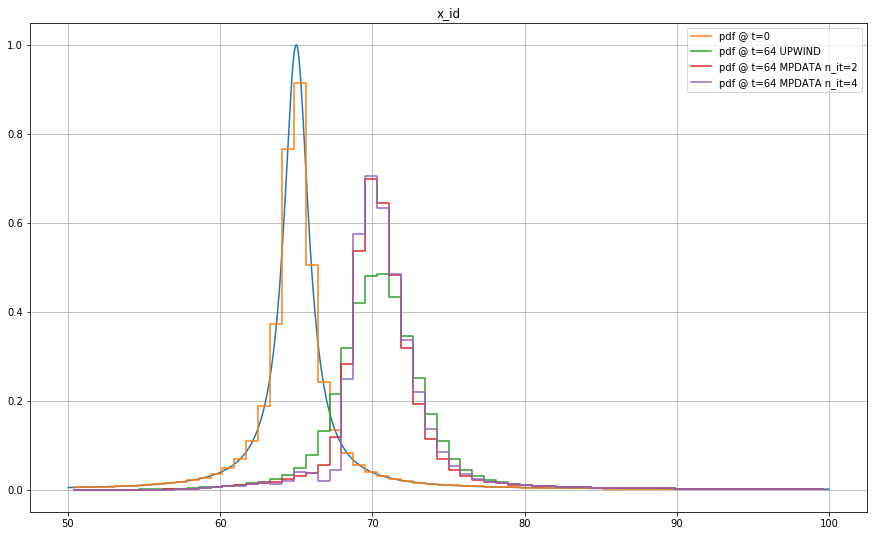

[1.17187500e-12 1.14533854e-12 1.12052682e-12 1.09726075e-12
 1.07538625e-12 1.05476991e-12 1.03529556e-12 1.01686152e-12
 9.99378358e-13 9.82767034e-13 9.66957418e-13 9.51887030e-13
 9.37500000e-13 9.23746198e-13 9.10580496e-13 8.97962142e-13
 8.85854234e-13 8.74223258e-13 8.63038704e-13 8.52272727e-13
 8.41899853e-13 8.31896728e-13 8.22241893e-13 8.12915596e-13
 8.03899618e-13 7.95177122e-13 7.86732523e-13 7.78551374e-13
 7.70620253e-13 7.62926680e-13 7.55459029e-13 7.48206454e-13
 7.41158827e-13 7.34306672e-13 7.27641118e-13 7.21153846e-13
 7.14837048e-13 7.08683387e-13 7.02685958e-13 6.96838262e-13
 6.91134169e-13 6.85567898e-13 6.80133984e-13 6.74827266e-13
 6.69642857e-13 6.64576130e-13 6.59622698e-13 6.54778402e-13
 6.50039292e-13 6.45401616e-13 6.40861807e-13 6.36416469e-13
 6.32062371e-13 6.27796435e-13 6.23615724e-13 6.19517438e-13
 6.15498904e-13 6.11557568e-13 6.07690991e-13 6.03896837e-13
 6.00172875e-13 5.96516965e-13 5.92927061e-13 5.89401200e-13
 5.85937500e-13]
[1.1718

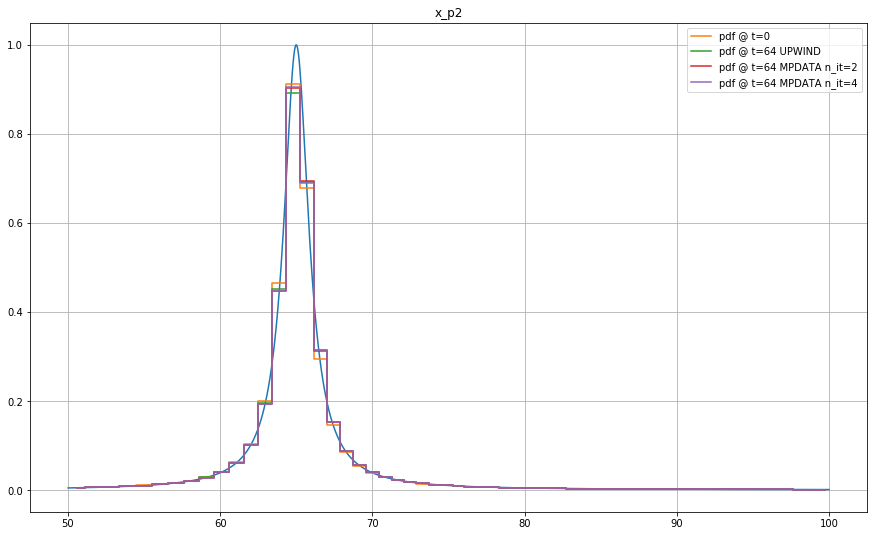

In [58]:
for fn in (x_id, x_p2, ): #TODO: p2
    plot_init()
    
    algos = (
        MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"label":"UPWIND",               "n_it":1}),
        MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"label":"MPDATA n_it=2",        "n_it":2, "dfl":False}),
        MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"label":"MPDATA n_it=4",        "n_it":4, "dfl":False}),
        #MPDATA(nr, r_min, r_max, dt, cdf0, fn(si), {"label":"MPDATA n_it=2 + dfl",  "n_it":2, "dfl":True})
    )

    plot_pdfr(r_min, r_max, cdf0)
    plot_step(algos[0].r, algos[0].pdf, "pdf @ t=0")

    for algo in algos:
        for t in range(nt): 
            algo.step(drdt)

    for algo in algos:
        plot_step(algo.r, algo.pdf, "pdf @ t=" + str(nt) + " " + algo.opts["label"])
    plot_done(fn.__name__)